# Import Libraries

In [2]:
import numpy as np 
import networkx as nx 
import os 
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
import plotly.colors as pc
from IPython.display import HTML

In [3]:
# import the data and creat
data_FBW = pd.read_csv('./data/FBW.csv', header=None, sep=';')
# show the first 5 rows
data_FBW.head()

0          1         2              3                             4   \
0  Wet clay  Modelling  Pressure  Wet smoothing                  Leather-hard   
1  Wet clay  Modelling   Coiling       Pressure  Application separate element   
2  Wet clay  Modelling   Coiling       Pressure  Application separate element   
3  Wet clay  Modelling   Coiling       Pressure  Application separate element   
4  Wet clay  Modelling  Pressure  Wet smoothing                  Leather-hard   

              5                6                  7                  8   \
0            Dry      Open firing                NaN                NaN   
1  Wet smoothing        Excisions       Leather-hard         Burnishing   
2  Wet smoothing  Simple incision  Simple impression       Leather-hard   
3       Scraping    Wet smoothing    Simple incision  Simple impression   
4            Dry      Open firing                NaN                NaN   

             9            10            11           12   13   14  
0           NaN          NaN           NaN          NaN  NaN  NaN  
1           Dry  Open firing  Incrustation          NaN  NaN  NaN  
2    Burnishing          Dry   Open firing          NaN  NaN  NaN  
3  Leather-hard   Burnishing           Dry  Open firing  NaN  NaN  
4           NaN          NaN           NaN          NaN  NaN  NaN

Low connected nodes: {('Simple incision', 'Simple impression', 'Excisions'), ('Wet smoothing', 'Leather-hard', 'Simple incision'), ('Simple impression', 'Simple incision', 'Leather-hard'), ('Excisions', 'Burnishing', 'Dry'), ('Leather-hard', 'Leather hard smoothing', 'Burnishing'), ('Simple incision', 'Leather-hard', 'Dry'), ('Coiling', 'Pressure', 'Leather-hard'), ('Pressure', 'Wet smoothing', 'Tilted impression'), ('Modelling', 'Pressure', 'Application separate element'), ('Application separate element', 'Wet smoothing', 'Tilted impression'), ('Wet smoothing', 'Leather-hard', 'Shining'), ('Excisions', 'Leather-hard', 'Simple incision'), ('Pressure', 'Application separate element', 'Scraping'), ('Pressure', 'Scraping', 'Application separate element'), ('Tilted impression', 'Leather-hard', 'Burnishing'), ('Leather hard smoothing', 'Burnishing', 'Dry'), ('Application', 'Simple incision', 'Simple impression'), ('Pressure', 'Leather-hard', 'Leather hard smoothing'), ('Wet smoothing', 'App

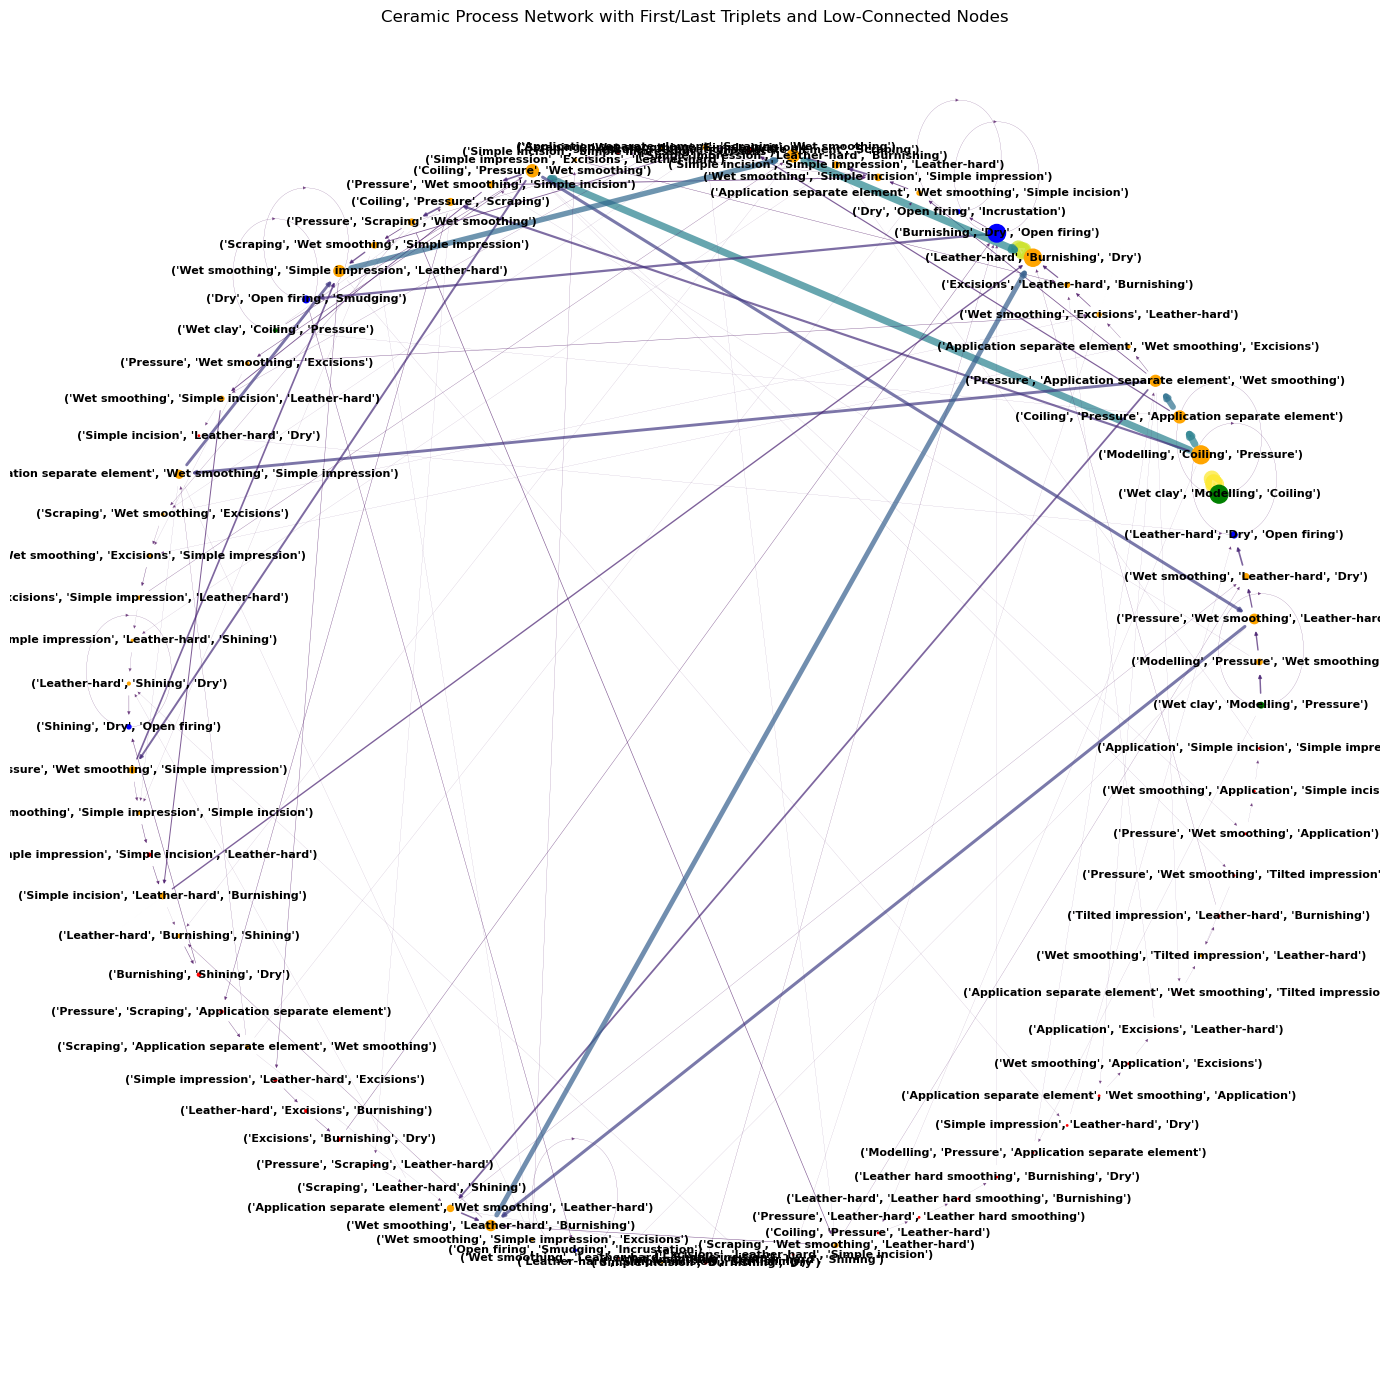

Number of unique triplet nodes: 81
Total triplet instances: 1573
Number of edges: 140
Number of first/last triplets with self-loops: 9
Number of low-connected nodes: 30


In [4]:
# Create the list of nodes and edges

def ceramic_graph_creation(data,  group_size = 3, num_data = 0, step = 1):
    """Create the ceramic graph from the dataset where each row is a work-chain of the pot. 

    Args:
        data: pandas dataset
        group_size
    """
    if num_data != 0:
        tot_data= num_data
    else:
        tot_data = len(data)
    unique_nodes = {}
    edges = []
    first_triplets = []  # To track first and last triplets in each row
    last_triplets = []  # To track first and last triplets in each row
    # Total number of rows in the data

    # Process your data to create triplet nodes
    for j in range(0,tot_data):  # For each row
        row_triplets = []  # To store valid triplets in this row
        for i in range(0, len(data.columns) - (group_size-1), step):
            # Extract triplet
            triplet = data.iloc[:, i:i+group_size].values[j].tolist()
            # Skip if any element in the triplet is NaN or empty
            if pd.isna(triplet).any() or '' in triplet:
                continue
        
            # Add node as a tuple of the triplet
            node_id = tuple(triplet)
            row_triplets.append(node_id)
            
            if node_id in unique_nodes:
                unique_nodes[node_id] += 1
            else:
                unique_nodes[node_id] = 1

        for node_a in row_triplets:
            for node_b in row_triplets:
                if group_size > 1: 
                    if node_a != node_b and node_a[1] == node_b[0] :
                        # Create only one edge between two nodes and add the weight
                        edges.append((node_a, node_b))
                else:
                    if node_a != node_b:
                        # Create only one edge between two nodes and add the weight
                        edges.append((node_a, node_b))
        # Store first and last triplet for this row if there are any valid triplets
        if len(row_triplets) > 0:
            first_triplets.append(row_triplets[0])
            last_triplets.append(row_triplets[-1])

    nodes = set(unique_nodes.keys())


    # add the weight of the edges based on the number of times they appear

    # Create a list of unique nodes


    # Add double self-edges for first and last triplets
    self_loop_nodes = set()
    first_triplets = set(first_triplets)
    last_triplets = set(last_triplets)
    for node in first_triplets:
        if node in unique_nodes:
            self_loop_nodes.add(node)
            edges.append((node, node))  # Add self-loop for first triplet
            edges.append((node, node))  # Add self-loop for first triplet again
    for node in last_triplets:
        if node in unique_nodes:
            self_loop_nodes.add(node)
            edges.append((node, node))  # Add self-loop for last triplet
            edges.append((node, node))  # Add self-loop for last triplet again
    # Create a graph from the list of nodes and edges
    G = nx.DiGraph()  # Using MultiDiGraph to allow multiple edges between same nodes

    # Add nodes with their count as an attribute
    for node, count in unique_nodes.items():
        G.add_node(node, count=count)
        
    # Add all edges
    edge_counts = Counter(edges)
    for edge, weight in edge_counts.items():
        u, v = edge
        G.add_edge(u, v, weight=weight)

    # Identify nodes with less than 2 connections 
    low_connected_nodes = []
    for node in G.nodes():
        if G.degree(node) <= 2:
            low_connected_nodes.append(node)

    low_connected_nodes = set(low_connected_nodes)  # Remove duplicates
    print(f"Low connected nodes: {low_connected_nodes}")
    return G, unique_nodes, nodes, self_loop_nodes, edges, edge_counts, first_triplets, last_triplets, low_connected_nodes

G, unique_nodes, nodes, self_loop_nodes, edges, edge_counts, first_triplets, last_triplets, low_connected_nodes = ceramic_graph_creation(data_FBW, group_size=3, step=1)




def plot_raw_graph(G, low_connected_nodes, self_loop_nodes, first_triplets, last_triplets, node_col = ['red', 'green', 'blue', 'orange']):
    """Plot the graph with nodes and edges, color-coded by group and size based on frequency."""
    # Draw the graph
    plt.figure(figsize=(14, 14))
    pos = nx.circular_layout(G, scale=0.5) 
    # Calculate node sizes based on their count (frequency)
    node_sizes = [(G.nodes[node]['count']) for node in G.nodes()]


    # Create color map - mark low connected nodes and self-loop nodes
    node_colors = []
    for node in G.nodes():
        if node in low_connected_nodes:
            node_colors.append(node_col[0])  # Low connected nodes in red
        elif node in self_loop_nodes:
            if node in first_triplets:
                node_colors.append(node_col[1])  # First/last triplets with self loops in green
            if node in last_triplets:
                node_colors.append(node_col[2])  # First/last triplets with self loops in green
        else:
            node_colors.append(node_col[3])  # Regular nodes in blue


    # Draw nodes - size reflects frequency, color reflects group
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

    # Draw edges with colors based on weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    total_weight = sum(edge_weights)
    
    # Create a colormap for the edges
    edge_cm = plt.cm.viridis  # Using plasma colormap
    normalized_weights = [w/max(edge_weights) for w in edge_weights]  # Normalize to 0-1
    edge_colors = [edge_cm(weight) for weight in normalized_weights]
    
    # Draw edges with width and color based on weight
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.7,
                          arrowsize=5, 
                          width=[100*w/total_weight for w in edge_weights],
                          edge_color=edge_colors)

    # Create node labels with formatted triplets and count
    node_labels = {node: f"{G[node]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title('Ceramic Process Network with First/Last Triplets and Low-Connected Nodes')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_raw_graph(G, low_connected_nodes, self_loop_nodes, first_triplets, last_triplets)

# Print some graph statistics
print(f"Number of unique triplet nodes: {G.number_of_nodes()}")
print(f"Total triplet instances: {sum(unique_nodes.values())}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of first/last triplets with self-loops: {len(self_loop_nodes)}")
print(f"Number of low-connected nodes: {len(low_connected_nodes)}")


In [5]:
# Get the nodes that are connected to one node note that the network is directed

def get_connected_nodes(G, node):
    """
    Get the nodes that are connected to a given node in the graph.
    """
    connected_nodes = set()
    # Get all nodes that are connected to the given node
    if G.is_directed():
        for neighbor in G.successors(node):
            connected_nodes.add(neighbor)
        for neighbor in G.predecessors(node):
            connected_nodes.add(neighbor)
    else:
        for neighbor in G.neighbors(node):
            connected_nodes.add(neighbor)
    # Get all nodes that are connected to the neighbors of the given node
    return connected_nodes
# Example usage
node = ('Modelling', 'Pressure', 'Wet smoothing')
connected_nodes = get_connected_nodes(G, node)
print(f"Nodes connected to {node}: {connected_nodes}")

Nodes connected to ('Modelling', 'Pressure', 'Wet smoothing'): {('Pressure', 'Wet smoothing', 'Leather-hard'), ('Wet clay', 'Modelling', 'Pressure'), ('Pressure', 'Wet smoothing', 'Simple incision')}


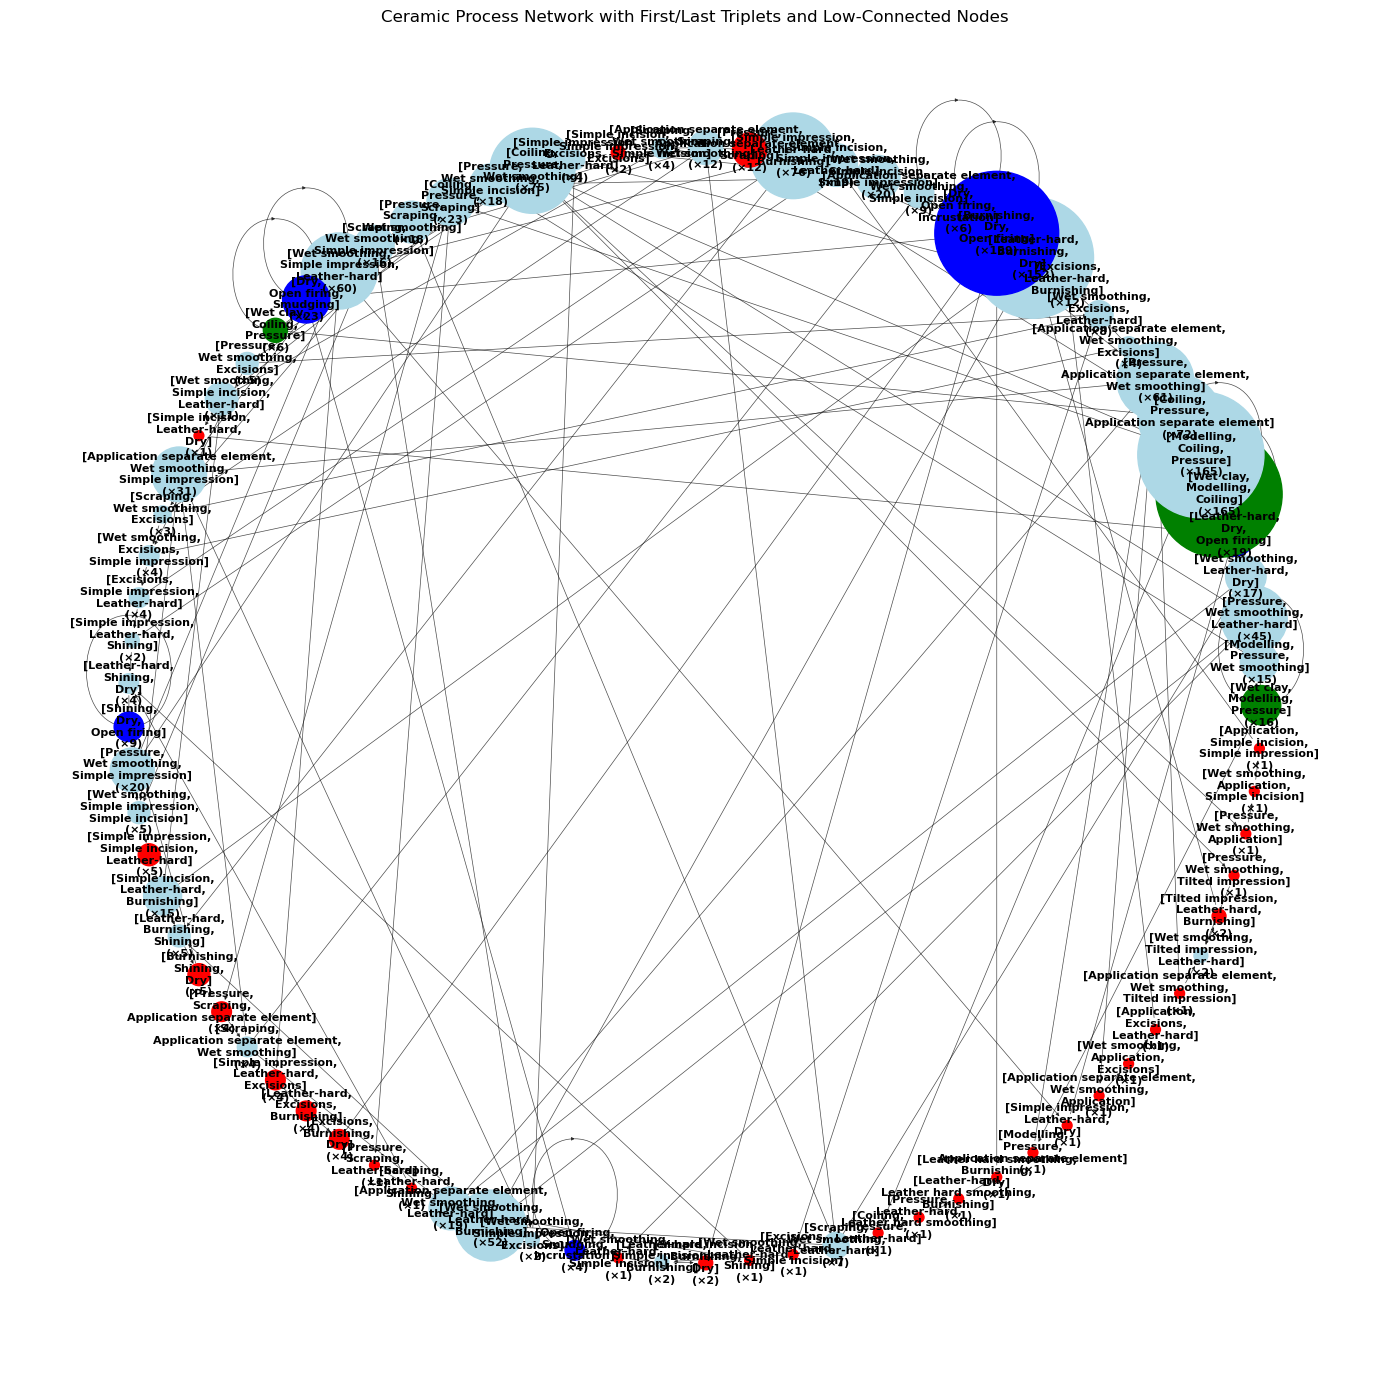

In [6]:
# check the existence of a link between two red nodes
G_C = G.copy()
# for node_a in low_connected_nodes:
#     for node_b in low_connected_nodes:
#         if node_a != node_b and G_C.has_edge(node_a, node_b):
#             print(f"Link exists between {node_a} and {node_b}")
#             # remove the nodes and the edge and create a new one 
#             # remove the edge and change the node_id by keeping the (first_node first name, - , second_node last name)
#             node_a_id = (f'{node_a[0]}', '-', f'{node_b[2]}')
#             # remove the edge
#             G_C.remove_edge(node_a, node_b)
#             G_C = nx.contracted_nodes(G_C,node_a, node_b)
#             # relabel the node
#             mapping = {node_a: node_a_id}
#             G_C = nx.relabel_nodes(G_C, mapping)
#     else:
#         continue

def contract_chain_nodes(G):
    G = G.copy()
    visited = set()
    components = []
    
    for node in G.nodes():
        if node in visited or G.degree(node) != 2:
            continue

        # Try to find maximal chain centered at this node
        chain = [node]
        pred = list(G.predecessors(node))
        succ = list(G.successors(node))

        # Walk backward
        while len(pred) == 1 and G.degree(pred[0]) == 2 and pred[0] not in visited:
            chain.insert(0, pred[0])
            visited.add(pred[0])
            pred = list(G.predecessors(pred[0]))

        # Walk forward
        while len(succ) == 1 and G.degree(succ[0]) == 2 and succ[0] not in visited:
            chain.append(succ[0])
            visited.add(succ[0])
            succ = list(G.successors(succ[0]))

        # Check that endpoints are not degree-2
        if len(chain) > 1:
            start, end = chain[0], chain[-1]
            if G.degree(start) > 2 and G.degree(end) > 2:
                components.append(chain)

    # Perform contraction
    for chain in components:
        supernode = ''.join(chain)
        G.add_node(supernode)

        # Redirect edges
        in_edges = []
        out_edges = []

        for node in chain:
            in_edges += [(u, supernode) for u in G.predecessors(node) if u not in chain]
            out_edges += [(supernode, v) for v in G.successors(node) if v not in chain]

        G.add_edges_from(in_edges)
        G.add_edges_from(out_edges)
        G.remove_nodes_from(chain)

    return G

G_C = contract_chain_nodes(G_C)

# draw the graph
plt.figure(figsize=(14, 14))
pos = nx.circular_layout(G_C, scale=0.5)  # Use shell layout for better visualization
# Calculate node sizes based on their count (frequency)
node_sizes = [(G_C.nodes[node]['count']*50) for node in G_C.nodes()]
# Create color map - mark low connected nodes and self-loop nodes
node_colors = []
for node in G_C.nodes():
    if node in low_connected_nodes:
        node_colors.append('red')  # Low connected nodes in red
    elif node in self_loop_nodes:
        if node in first_triplets:
            node_colors.append('green')  # First/last triplets with self loops in green
        if node in last_triplets:
            node_colors.append('blue')
    else:
        node_colors.append('lightblue')  # Regular nodes in blue

# Draw nodes - size reflects frequency, color reflects group
nx.draw_networkx_nodes(G_C, pos, node_size=node_sizes, node_color=node_colors)
# Draw edges
nx.draw_networkx_edges(G_C, pos, width=0.5, alpha=0.7, arrowsize=5)
# Create node labels with formatted triplets and count
node_labels = {node: f"[{node[0]},\n{node[1]},\n{node[2]}]\n(×{G_C.nodes[node]['count']})" for node in G_C.nodes()}
nx.draw_networkx_labels(G_C, pos, labels=node_labels, font_size=8, font_weight='bold')
plt.title('Ceramic Process Network with First/Last Triplets and Low-Connected Nodes')
plt.axis('off')
plt.tight_layout()
plt.show()


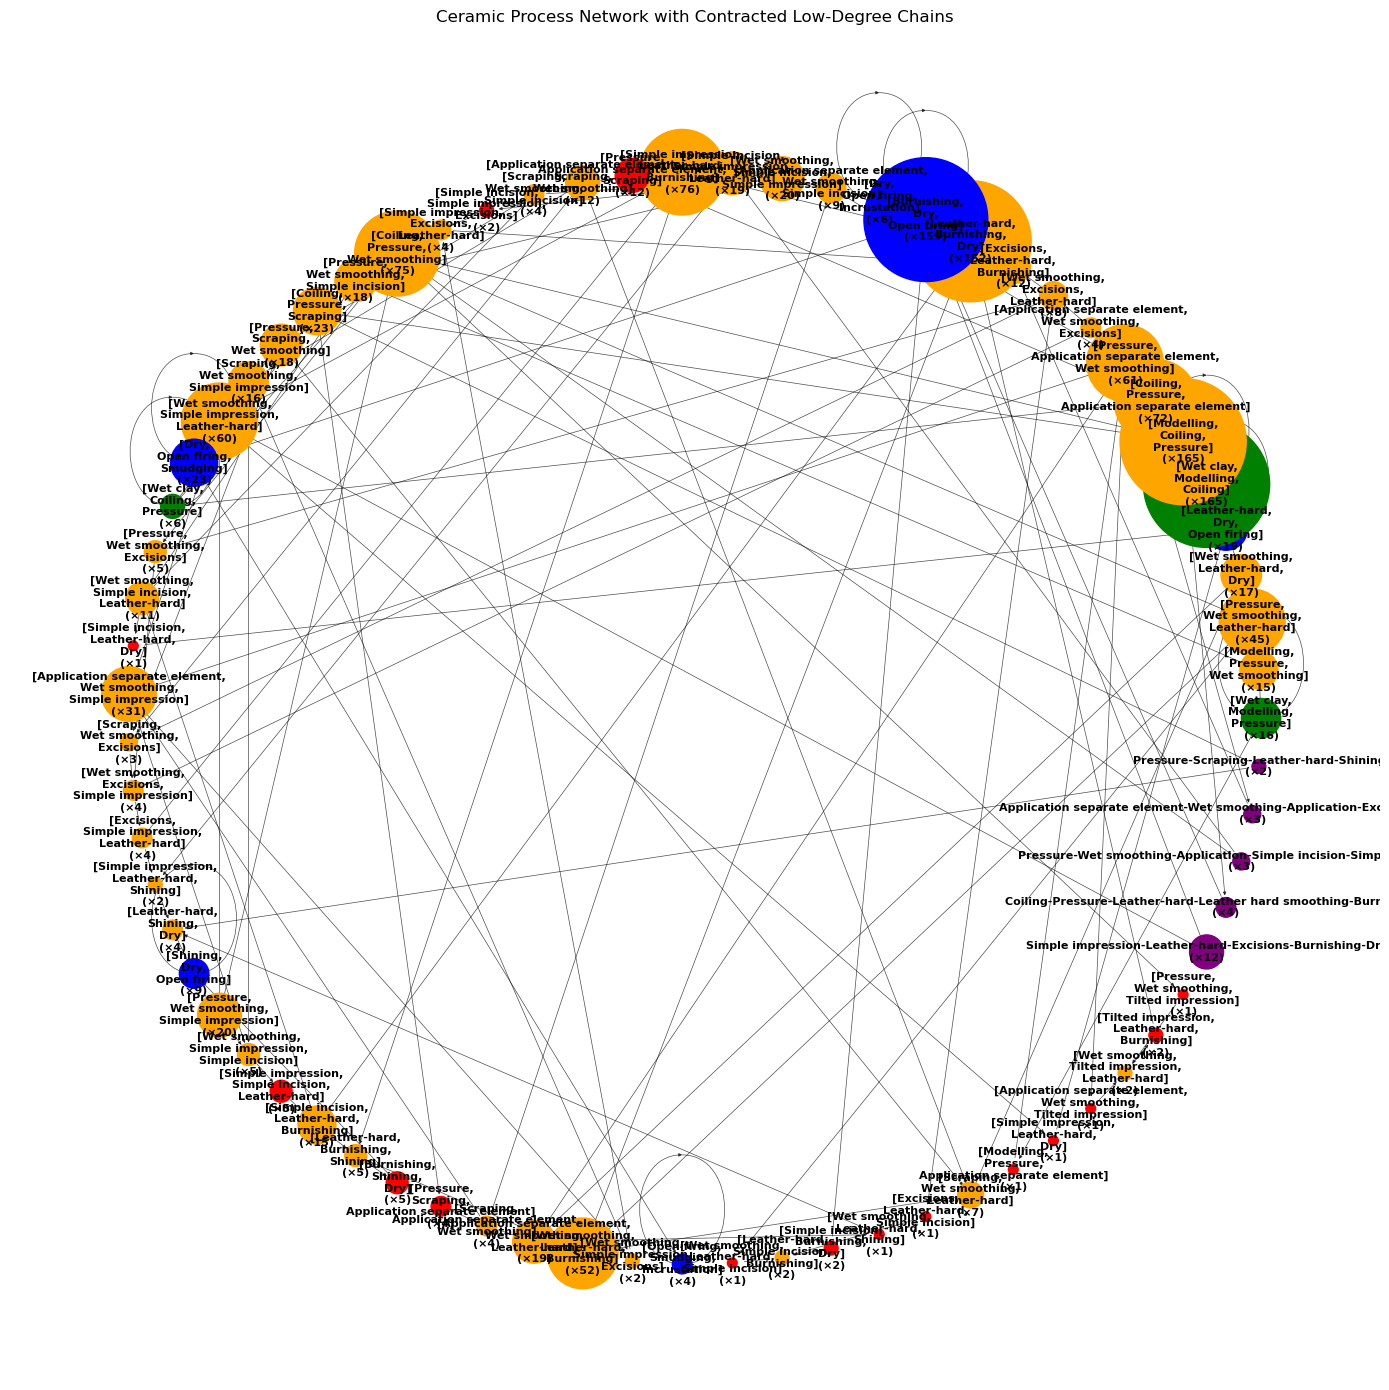

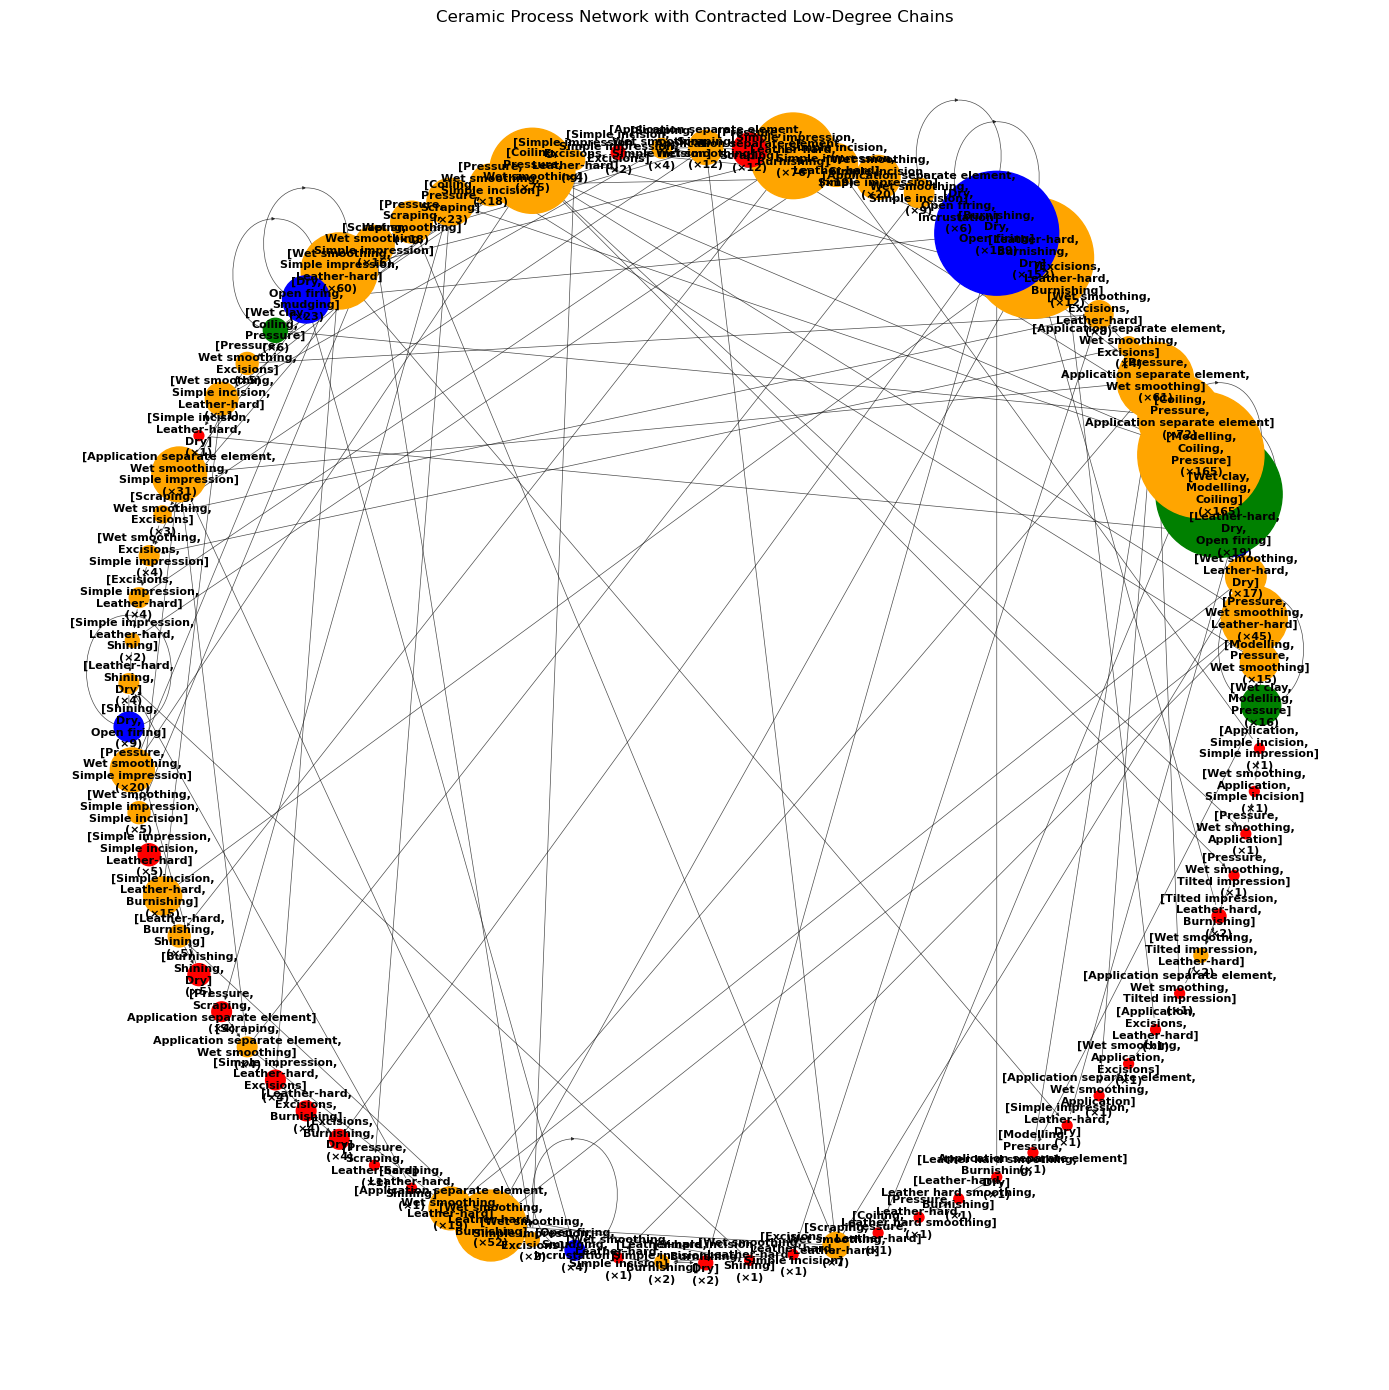

Number of unique triplet nodes after contraction: 71
Total triplet instances after contraction: 1573
Number of edges after contraction: 130
Number of contracted nodes: 5


In [7]:
def contract_low_degree_chains(G):
    """
    Contract chains of nodes where each node has total in+out degree ≤ 2.
    The new node will combine the names of the contracted nodes while maintaining
    the triplet structure.
    
    Returns:
        - The contracted graph
        - A set of contracted node IDs
    """
    G = G.copy()
    visited = set()
    components = []
    contracted_nodes = set()  # Track contracted nodes
    
    # First identify all nodes with in+out degree ≤ 2
    low_degree_nodes = set()
    for node in G.nodes():
        # Calculate total in+out degree
        total_degree = G.in_degree(node) + G.out_degree(node)
        if total_degree <= 2:
            low_degree_nodes.add(node)
    
    # Find chains of low-degree nodes between high-degree nodes
    for node in low_degree_nodes:
        if node in visited:
            continue
            
        # Start a new chain
        chain = [node]
        visited.add(node)
        
        # Expand forward if there's a single successor with low degree
        current = node
        while True:
            successors = list(G.successors(current))
            if len(successors) != 1:
                break
                
            next_node = successors[0]
            if next_node in visited or next_node not in low_degree_nodes:
                break
                
            chain.append(next_node)
            visited.add(next_node)
            current = next_node
            
        # Expand backward if there's a single predecessor with low degree
        current = node
        while True:
            predecessors = list(G.predecessors(current))
            if len(predecessors) != 1:
                break
                
            prev_node = predecessors[0]
            if prev_node in visited or prev_node not in low_degree_nodes:
                break
                
            chain.insert(0, prev_node)
            visited.add(prev_node)
            current = prev_node
        
        # If we found a chain with at least 2 nodes, save it
        if len(chain) >= 2:
            components.append(chain)
    
    # Contract each identified chain
    for chain in components:
        # Create a new node ID that combines the chain's nodes
        # For triplets we'll create a new triplet combining first and last node
        first_node = chain[0]
        last_node = chain[-1]
        
        # Create a new triplet that combines information from both end nodes
        if len(first_node) == 3 and len(last_node) == 3:
            # Combine the first part that combine the whole chain 
            new_node_id = f"{first_node[0]}-"
            for ch in range(1, len(chain), 1):
                new_node_id += f"{chain[ch][0]}-"
            
            new_node_id += f"{last_node[1]}-{last_node[2]}"
            #new_node_id = (f"{first_node[0]}", f"{first_node[1]}-{last_node[1]}", f"{last_node[2]}")
        else:
            # If nodes are not triplets, just combine their string representations
            new_node_id = f"{first_node}+{last_node}"
            
        # Mark this as a contracted node
        contracted_nodes.add(new_node_id)
            
        # Add the new node with combined count attribute
        total_count = sum(G.nodes[node].get('count', 0) for node in chain)
        G.add_node(new_node_id, count=total_count)
        
        # Find all incoming edges to the chain (except within-chain edges)
        in_edges = []
        for node in chain:
            for pred in G.predecessors(node):
                if pred not in chain:
                    in_edges.append((pred, new_node_id, G[pred][node].get('weight', 1)))
        
        # Find all outgoing edges from the chain (except within-chain edges)
        out_edges = []
        for node in chain:
            for succ in G.successors(node):
                if succ not in chain:
                    out_edges.append((new_node_id, succ, G[node][succ].get('weight', 1)))
        
        # Add the new edges with weights
        for u, v, w in in_edges:
            G.add_edge(u, v, weight=w)
        for u, v, w in out_edges:
            G.add_edge(u, v, weight=w)
        
        # Remove the original nodes in the chain
        G.remove_nodes_from(chain)
    
    return G, contracted_nodes

# Use the modified function
G_C, contracted_nodes = contract_low_degree_chains(G.copy())

def plot_raw_graph_2(G_C, low_connected_nodes, self_loop_nodes, first_triplets, last_triplets, contracted_nodes=[], node_col = ['red', 'green', 'blue', 'orange', 'purple']):
# Now update the visualization with the new color for contracted nodes
    # Draw the contracted graph
    plt.figure(figsize=(14, 14))
    pos = nx.circular_layout(G_C, scale=0.5)
    node_sizes = [(G_C.nodes[node]['count']*50) for node in G_C.nodes()]

    # Create color map with purple for contracted nodes
    node_colors = []
    for node in G_C.nodes():
        if node in contracted_nodes and len(contracted_nodes)>0:
            node_colors.append(node_col[-1])  # Contracted nodes in purple
        elif node in low_connected_nodes:
            node_colors.append(node_col[0])  # Low connected nodes in red
        elif node in self_loop_nodes:
            if node in first_triplets:
                node_colors.append(node_col[1])  # First triplets with self loops in green
            if node in last_triplets:
                node_colors.append(node_col[2])  # Last triplets with self loops in blue
        else:
            node_colors.append(node_col[3])  # Regular nodes in blue

    # Rest of the drawing code remains the same
    nx.draw_networkx_nodes(G_C, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_edges(G_C, pos, width=0.5, alpha=0.7, arrowsize=5)

    # Create node labels
    def format_node_label(node):
        if isinstance(node, tuple) and len(node) == 3:
            return f"[{node[0]},\n{node[1]},\n{node[2]}]\n(×{G_C.nodes[node]['count']})"
        else:
            return f"{node}\n(×{G_C.nodes[node]['count']})"

    node_labels = {node: format_node_label(node) for node in G_C.nodes()}
    nx.draw_networkx_labels(G_C, pos, labels=node_labels, font_size=8, font_weight='bold')

    plt.title('Ceramic Process Network with Contracted Low-Degree Chains')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_raw_graph_2(G_C, low_connected_nodes, self_loop_nodes, first_triplets, last_triplets, contracted_nodes)

plot_raw_graph_2(G, low_connected_nodes, self_loop_nodes, first_triplets, last_triplets)

# Print some graph statistics
print(f"Number of unique triplet nodes after contraction: {G_C.number_of_nodes()}")
print(f"Total triplet instances after contraction: {sum(G_C.nodes[node]['count'] for node in G_C.nodes())}")
print(f"Number of edges after contraction: {G_C.number_of_edges()}")
print(f"Number of contracted nodes: {len(contracted_nodes)}")


In [15]:
def enhanced_sankey_diagram(G, filename, title, node_colors = ['red', 'green', 'blue', 'lightblue', 'purple']):
    # Create a mapping from node to index
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    
    # Prepare node data
    numeric_labels = []
    full_labels = []
    colors = []
    node_types = []  # For legend grouping
    
    for i, node in enumerate(G.nodes()):
        # Create numeric labels for nodes
        numeric_labels.append(f"{i}")
        
        # Create full labels for legend
        if len(node) == 3:  # Regular triplet
            full_labels.append(f"{node[0]}-{node[1]}-{node[2]}")
        else:  # For contracted nodes print the node name

            full_labels.append(f"{node}")
        
        # Determine node type for coloring and legend
        if node in contracted_nodes:
            colors.append(node_colors[-1])  
            node_types.append('Contracted Chain')
        elif node in first_triplets:
            colors.append(node_colors[1])  
            node_types.append('Starting Process')
        elif node in last_triplets:
            colors.append(node_colors[2])  
            node_types.append('Ending Process')
        elif node in low_connected_nodes:
            colors.append(node_colors[0])  
            node_types.append('Low-Connected Process')
        else:
            colors.append(node_colors[3]) 
            node_types.append('Intermediate Process')
            
    
    
    # Prepare link data
    sources = []
    targets = []
    values = []
    link_colors = []
    
    # Find all paths from green to blue nodes to identify main flows
    main_paths = []
    main_path_weights = []
    
    # Helper to find paths (with weights) between any two nodes
    def find_weighted_paths(source, target):
        try:
            paths = list(nx.all_simple_paths(G, source, target, cutoff=10))
            path_weights = []
            
            for path in paths:
                # Calculate the weight as minimum edge weight along the path
                edge_weights = [G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1)]
                if edge_weights:
                    path_weights.append(min(edge_weights))
                else:
                    path_weights.append(0)
                    
            return paths, path_weights
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return [], []
    
    # Find paths from each green node to each blue node
    for start in first_triplets:
        for end in last_triplets:
            paths, weights = find_weighted_paths(start, end)
            main_paths.extend(paths)
            main_path_weights.extend(weights)
    
    # Sort paths by weight to emphasize the most common ones
    sorted_paths = [x for _, x in sorted(zip(main_path_weights, main_paths), 
                                         key=lambda pair: pair[0], reverse=True)]
    
    # Get the top paths and their weights for the colorscale - USE VIRIDIS
    top_path_count = min(10, len(sorted_paths))  # Use up to 10 main paths
    
    # Generate Viridis colorscale - either use built-in or sample points from it
    # Option 1: Use sequential Viridis palette

    viridis_palette = pc.sequential.Plasma
    # Reverse the colorscale so darkest blue is the most important path
    main_path_colors = viridis_palette[::-1][:top_path_count]
    
    # Create a mapping of edges to their path rank
    edge_path_rank = {}
    for i, path in enumerate(sorted_paths[:top_path_count]):
        for j in range(len(path)-1):
            edge = (path[j], path[j+1])
            # If edge already exists in a higher-ranked path, don't overwrite
            if edge not in edge_path_rank or edge_path_rank[edge] > i:
                edge_path_rank[edge] = i

    # Add all edges to the Sankey diagram
    for u, v in G.edges():
        # Skip self-loops
        if u == v:
            continue
        # Get node indices

        u_idx = node_mapping[u]
        v_idx = node_mapping[v]
        
        # Get edge weight
        weight = G[u][v]['weight']
        
        sources.append(u_idx)
        targets.append(v_idx)
        values.append(weight)
        
        # Assign color based on path importance
        edge = (u, v)
        if edge in edge_path_rank:
            # Use color from the Viridis colorscale based on path rank
            path_rank = edge_path_rank[edge]
            if path_rank < len(main_path_colors):
                link_colors.append(main_path_colors[path_rank])
            else:
                link_colors.append(main_path_colors[-1])  # Use last color if rank exceeds available colors
        elif u in first_triplets:
            link_colors.append('rgba(0, 200, 0, 0.5)')    # Green-tinted
        elif v in last_triplets:
            link_colors.append('rgba(0, 0, 200, 0.5)')    # Blue-tinted
        else:
            link_colors.append('rgba(180, 180, 180, 0.3)') # Gray for regular paths
    
    # Create the Sankey diagram
    sankey_trace = go.Sankey(
        arrangement='freeform',
        node=dict(
            pad=60,
            thickness=40,
            line=dict(color="black", width=0.8),
            label=numeric_labels,  # Use numeric labels instead of full text
            color=colors,
            customdata=full_labels,  # Store full labels for hover
            hovertemplate='Node %{label}<br>' +
            'Full Name: %{customdata}<br>' +
            'Count: %{value}<extra></extra>',
            align='right',
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            # Create custom data array with source and target full names
            customdata=[[full_labels[s], full_labels[t], G[list(G.nodes())[s]][list(G.nodes())[t]]['weight']] 
                    for s, t in zip(sources, targets)],
            hovertemplate='<b>Connection</b><br>' +
            'From: %{customdata[0]}<br>' +
            'To: %{customdata[1]}<br>' +
            'Weight: %{customdata[2]}<extra></extra>',
            # Set the width of the lines based on the weight
        )
            # Show weight on hover

            #hoverinfo='text',
            #hovertext=[f"Weight: {val}" for val in values] 


)
    node_type_legend = [
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=15, color='green'),
            name='Starting Process', showlegend=True
        ),
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=15, color='blue'),
            name='Ending Process', showlegend=True
        ),
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=15, color='lightblue'),
            name='Intermediate Process', showlegend=True
        ),
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=15, color='red'),
            name='Low-Connected Process', showlegend=True
        ),
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=15, color='purple'),
            name='Contracted Chain', showlegend=True
        ),
        go.Scatter(
            x=[None], y=[None], mode='lines',
            line=dict(width=4, color='rgba(180, 180, 180, 0.3)'),
            name='Other Connection', showlegend=True
        )
    ]
    
    # Add path rank legend entries
    path_legend = []
    for i in range(top_path_count):
        path_legend.append(
            go.Scatter(
                x=[None], y=[None], mode='lines',
                line=dict(width=6, color=main_path_colors[i]),
                name=f'Main Path (Rank {i+1})', showlegend=True
            )
        )
    
    # Create legend entries for node numbers with their full names
    # Group by node type to organize the legend
    node_number_legend = []
    
    # Add a header for the node mapping section
    node_number_legend.append(
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=0, color="rgba(0,0,0,0)"),
            name="<b>--- Node Numbers ---</b>", 
            showlegend=True
        )
    )
    
    # Add entries for each node, but limit to at most 20 (to avoid legend overflow)
    # Sort them by type, then number for better organization
    node_info = [(i, full_labels[i], colors[i], node_types[i]) 
                 for i, _ in enumerate(G.nodes())]
    
    # Sort by node type first, then by node number
    node_info.sort(key=lambda x: (x[3], x[0]))
    
    # Add limited number of nodes to legend
    max_legend_nodes = min(20, len(node_info))
    for i in range(max_legend_nodes):
        node_idx, label, color, node_type = node_info[i]
        node_number_legend.append(
            go.Scatter(
                x=[None], y=[None], mode='markers',
                marker=dict(size=8, color=color),
                name=f"Node {node_idx}: {label}",
                showlegend=True
            )
        )
    
    # Add note if not all nodes are shown
    if len(node_info) > max_legend_nodes:
        node_number_legend.append(
            go.Scatter(
                x=[None], y=[None], mode='markers',
                marker=dict(size=3, color="rgba(0,0,0,0)"),
                name=f"... and {len(node_info) - max_legend_nodes} more nodes", 
                showlegend=True
            )
        )
    
    # Combine all legend traces
    legend_traces = path_legend +  node_type_legend #+ node_number_legend +
    # Combine traces and create figure
    # Combine traces and create figure
    fig = go.Figure(data=[sankey_trace] + legend_traces)
    
    # Update layout for better legend display
    fig.update_layout(
        title_text=f"Ceramic Process Flow Network - {title}",
        font_size=12,
        showlegend=True,
        legend=dict(
            orientation="v",  # Change to vertical for more space
            yanchor="top",
            y=1,
            xanchor="right",
            x=1.15,  # Move legend to right of plot
            traceorder="grouped",  # Keep legend entries grouped
            itemsizing="constant"  # Make legend item sizes consistent
        ),
        # Completely remove axes
        xaxis=dict(
            showgrid=False, 
            zeroline=False, 
            showticklabels=False,
            showline=False,
            visible=False
        ),
        yaxis=dict(
            showgrid=False, 
            zeroline=False, 
            showticklabels=False,
            showline=False,
            visible=False
        ),
        # Add more right margin for the legend
        margin=dict(l=20, r=150, t=50, b=50),
        plot_bgcolor='white',
        paper_bgcolor='white',
        # Adjust dimensions to accommodate legend
        width=1300,
        height=900
    )
    
    # Save to HTML file
    fig.write_html(filename, include_plotlyjs='cdn', full_html=True)
    
    return fig

# Generate the enhanced Sankey diagram with Viridis colorscale
fig = enhanced_sankey_diagram(G_C, filename="./viridis-sankey-FBW.html", title="Funnel Beaker Ware",)

# Display the HTML file

# Read the file content first
with open("./viridis-sankey-FBW.html", "r", encoding="utf-8") as f:
    html_content = f.read()
# Display the HTML content
HTML(html_content, metadata=dict(width=800, height=1600))

Low connected nodes: {('Simple incision', 'Excisions', 'Leather-hard'), ('Simple impression', 'Simple incision', 'Excisions'), ('Wet smoothing', 'Application', 'Simple impression'), ('Leather-hard', 'Dry', 'Burnishing'), ('Wet smoothing', 'Leather-hard', 'Burnishing'), ('Application separate element', 'Wet smoothing', 'Simple incision'), ('Scraping', 'Wet smoothing', 'Application'), ('Wet smoothing', 'Simple incision', 'Tilted impression'), ('Wet smoothing', 'Leather-hard', 'Shining'), ('Tilted impression', 'Leather-hard', 'Burnishing'), ('Application separate element', 'Wet smoothing', 'Simple impression'), ('Scraping', 'Wet smoothing', 'Tilted impression'), ('Application', 'Simple impression', 'Leather-hard'), ('Wet smoothing', 'Simple impression', 'Excisions'), ('Wet smoothing', 'Tilted impression', 'Leather-hard'), ('Simple impression', 'Excisions', 'Leather-hard'), ('Coiling', 'Pressure', 'Application separate element'), ('Modelling', 'Pressure', 'Wet smoothing'), ('Simple incisio

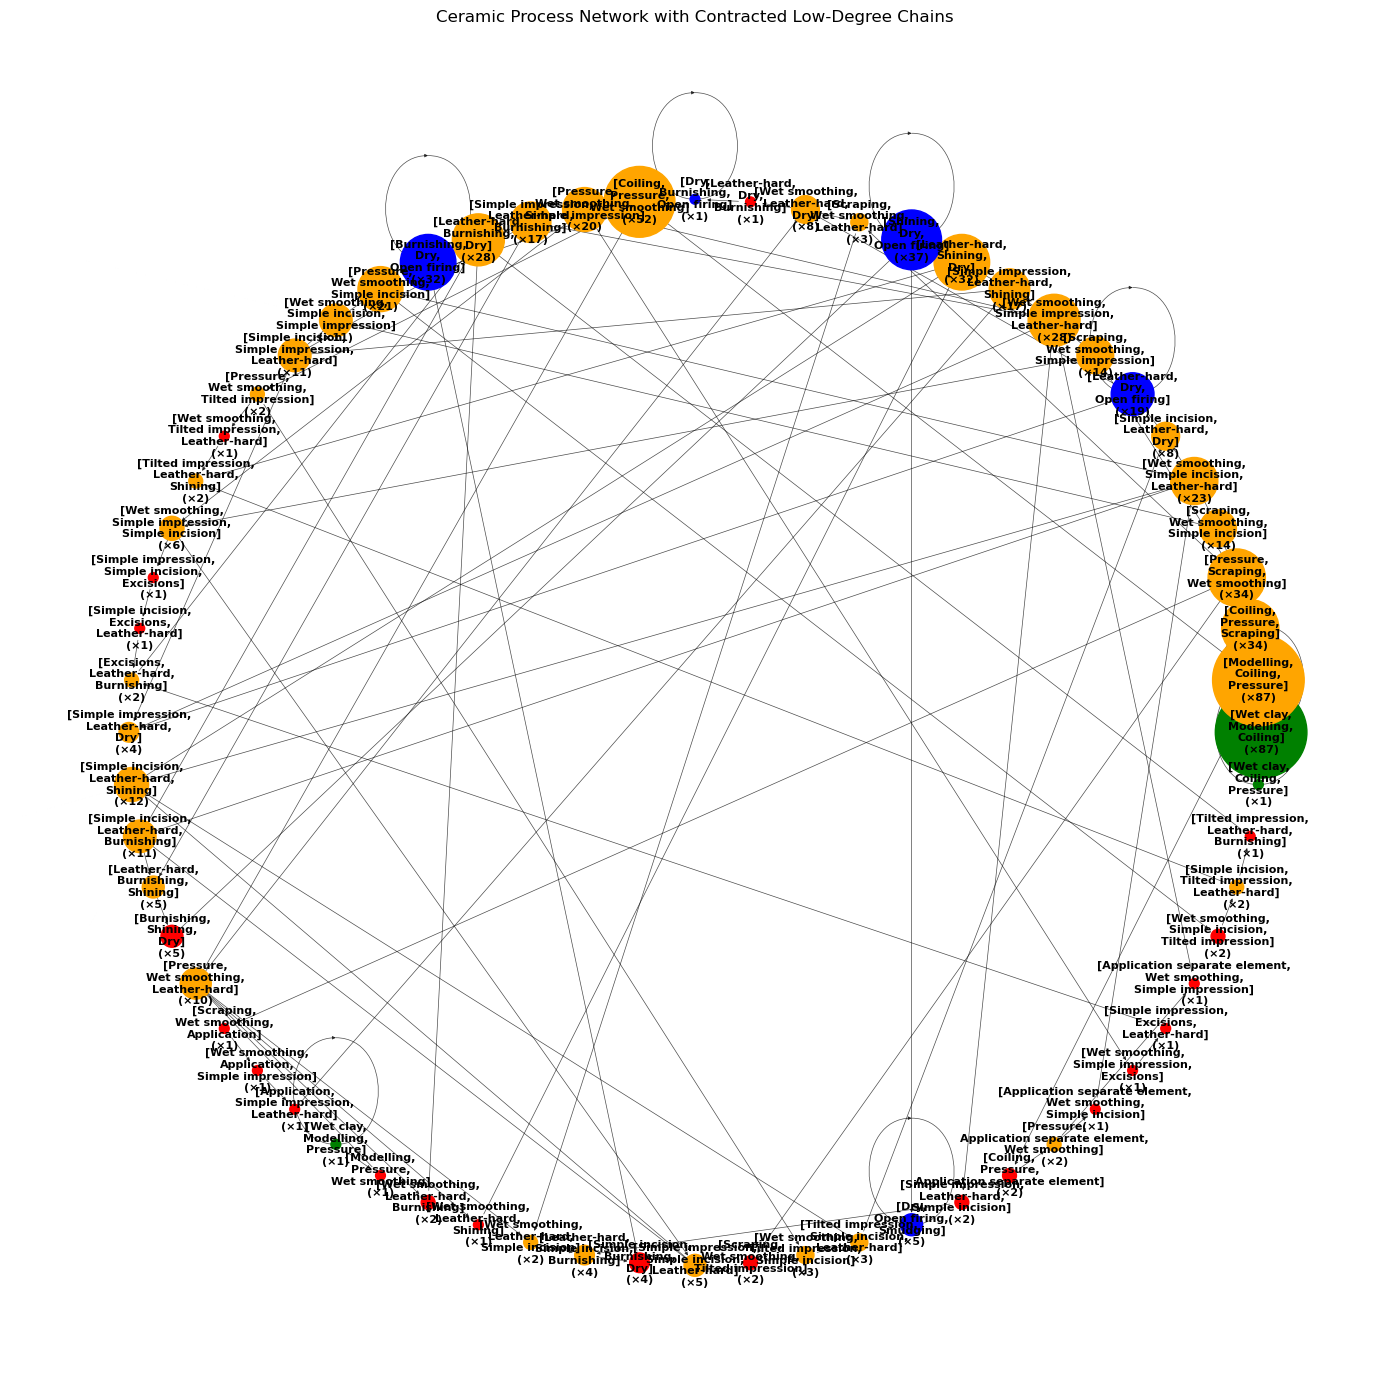

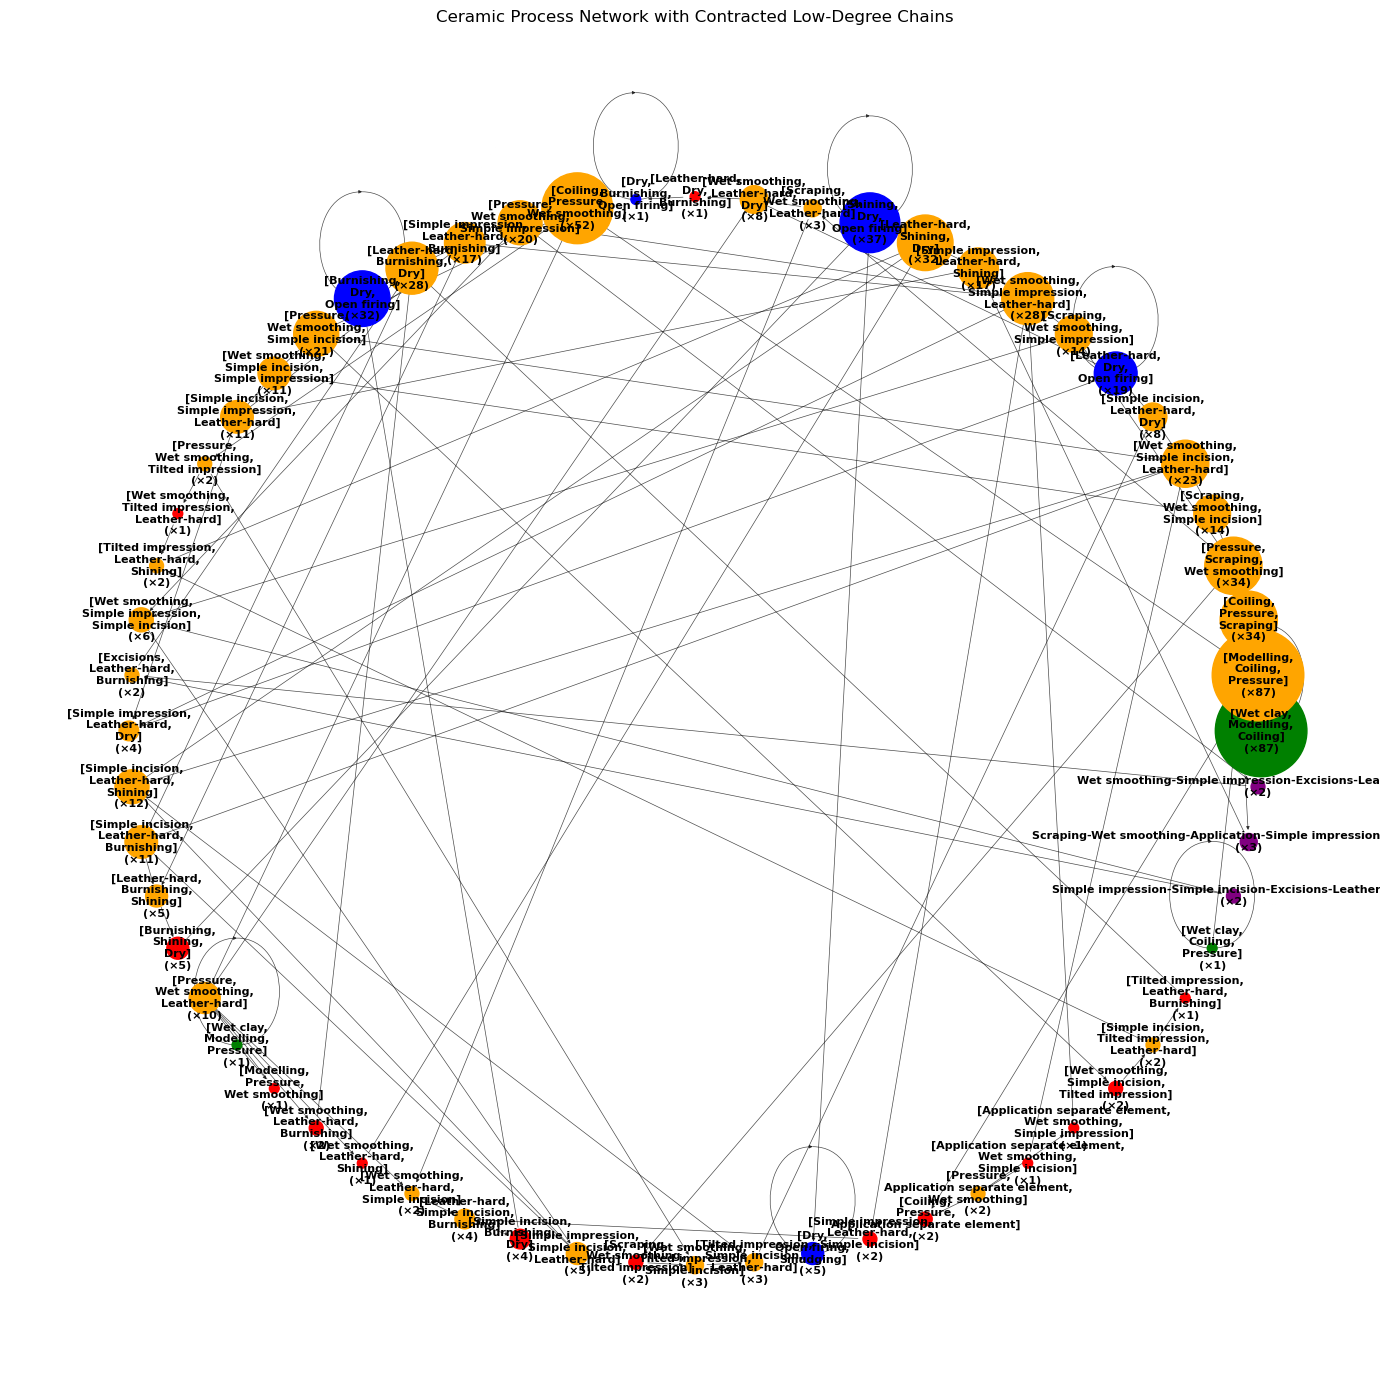

In [16]:
# Next step Is to create a new sankey with a new dataset and want to compare the two in the same figure to show the influences
# Create a new dataset with the same structure as the first one
data_CW2 = pd.read_csv('./data/CW.csv', header=None, sep=';')
# show the first 5 rows
data_CW2.head()


G_CW, unique_nodes_CW, nodes_CW, self_loop_nodes_CW, edges_CW, edge_counts_CW, first_triplets_CW, last_triplets_CW, low_connected_nodes_CW = ceramic_graph_creation(data_CW2)

plot_raw_graph_2(G_CW, low_connected_nodes_CW, self_loop_nodes_CW, first_triplets_CW, last_triplets_CW)
# Print some graph statistics

G_CW_c, contracted_nodes_CW = contract_low_degree_chains(G_CW.copy())
plot_raw_graph_2(G_CW_c, low_connected_nodes_CW, self_loop_nodes_CW, first_triplets_CW, last_triplets_CW, contracted_nodes=contracted_nodes_CW)

# Plot Sankey diagram for the new dataset
fig_CW = enhanced_sankey_diagram(G_CW_c, filename="./viridis-sankey-CW.html", title = 'Corded Ware')
# Display the HTML file
# Read the file content first
with open("./viridis-sankey-CW.html", "r", encoding="utf-8") as f:
    html_content_CW = f.read()
# Display the HTML content
HTML(html_content_CW, metadata=dict(width=800, height=1600))



In [17]:
def merged_sankey_diagram(G1, G2, contracted_nodes1, contracted_nodes2, 
                         first_triplets1, first_triplets2, 
                         last_triplets1, last_triplets2,
                         low_connected_nodes1, low_connected_nodes2,
                         filename, node_colors=['red', 'green', 'blue', 'lightblue', 'purple']):
    """
    Create a merged Sankey diagram from two separate graphs.
    Cross-graph links are colored red.
    """
    # Create a merged graph
    G_merged = nx.DiGraph()
    
    # Add all nodes from both graphs with their attributes and track origin
    for node, attr in G1.nodes(data=True):
        G_merged.add_node(node, **attr, origin='G1')
    
    for node, attr in G2.nodes(data=True):
        if node in G_merged:
            # If the node already exists, update its attributes but mark as from both
            G_merged.nodes[node]['origin'] = 'G2'
            # Sum the count if both graphs have this node
            if 'count' in G_merged.nodes[node] and 'count' in attr:
                G_merged.nodes[node]['count'] += attr['count']
        else:
            G_merged.add_node(node, **attr, origin='G2')
    
    # Add all edges from both graphs
    for u, v, attr in G1.edges(data=True):
        G_merged.add_edge(u, v, **attr, origin='G1')
    
    for u, v, attr in G2.edges(data=True):
        if G_merged.has_edge(u, v):
            # If the edge already exists, increment its weight
            G_merged[u][v]['weight'] += attr['weight']
            G_merged[u][v]['origin'] = 'G2'
        else:
            G_merged.add_edge(u, v, **attr, origin='G2')
    
    # Combine sets of special nodes
    all_contracted_nodes = set()
    all_contracted_nodes.update(contracted_nodes1)
    all_contracted_nodes.update(contracted_nodes2)
    
    all_first_triplets = set()
    all_first_triplets.update(first_triplets1)
    all_first_triplets.update(first_triplets2)
    
    all_last_triplets = set()
    all_last_triplets.update(last_triplets1)
    all_last_triplets.update(last_triplets2)
    
    all_low_connected = set()
    all_low_connected.update(low_connected_nodes1)
    all_low_connected.update(low_connected_nodes2)
    
    # Create a mapping from node to index
    node_mapping = {node: i for i, node in enumerate(G_merged.nodes())}
    
    # Prepare node data
    numeric_labels = []
    full_labels = []
    colors = []
    node_types = []
    origins = []
    
    # Scale node thicknesses based on count values
    min_thickness = 30
    max_thickness = 100
    node_counts = [G_merged.nodes[node].get('count', 1) for node in G_merged.nodes()]
    min_count = min(node_counts)
    max_count = max(node_counts) 
    count_range = max_count - min_count if max_count > min_count else 1
    
    # Process each node
    for i, node in enumerate(G_merged.nodes()):
        # Create numeric labels
        numeric_labels.append(f"{i}")
        
        # Create full labels
        if isinstance(node, tuple) and len(node) == 3:
            full_labels.append(f"{node[0]}-{node[1]}-{node[2]}")
        else:
            full_labels.append(f"{node}")
        
        # Track node origin
        origin = G_merged.nodes[node]['origin']
        origins.append(origin)
        
        # Determine node type & color
        if node in all_contracted_nodes:
            colors.append(node_colors[-1])
            node_types.append('Contracted Chain')
        elif node in all_first_triplets:
            colors.append(node_colors[1])
            node_types.append('Starting Process')
        elif node in all_last_triplets:
            colors.append(node_colors[2])
            node_types.append('Ending Process')
        elif node in all_low_connected:
            colors.append(node_colors[0])
            node_types.append('Low-Connected Process')
        else:
            colors.append(node_colors[3])
            node_types.append('Intermediate Process')
    
    # Calculate node thicknesses based on count
    node_thicknesses = []
    for count in node_counts:
        if count_range == 1:
            scaled_thickness = (min_thickness + max_thickness) // 2
        else:
            scaled_thickness = min_thickness + ((count - min_count) / count_range) * (max_thickness - min_thickness)
        node_thicknesses.append(int(scaled_thickness))
    
    # Prepare link data
    sources = []
    targets = []
    values = []
    link_colors = []
    
    # Process each edge
    for u, v, attrs in G_merged.edges(data=True):
        # Skip self-loops
        if u == v:
            continue
            
        u_idx = node_mapping[u]
        v_idx = node_mapping[v]
        weight = attrs['weight']
        origin = attrs['origin']
        
        sources.append(u_idx)
        targets.append(v_idx)
        values.append(weight)
        
        # Assign color based on link origin and node origins
        if origin == 'both':
            # Links that exist in both graphs
            link_colors.append('rgba(100, 0, 100, 0.7)')  # Purple for shared links
        elif G_merged.nodes[u]['origin'] != G_merged.nodes[v]['origin'] and G_merged.nodes[u]['origin'] != 'both' and G_merged.nodes[v]['origin'] != 'both':
            # Links that go between different graphs - HIGHLIGHT THESE RED
            link_colors.append('rgba(255, 0, 0, 0.7)')  # Red for cross-graph links
        elif u in all_first_triplets:
            link_colors.append('rgba(0, 200, 0, 0.5)')  # Green-tinted for start nodes
        elif v in all_last_triplets:
            link_colors.append('rgba(0, 0, 200, 0.5)')  # Blue-tinted for end nodes
        else:
            link_colors.append('rgba(180, 180, 180, 0.3)')  # Gray for regular links
    
    # Create the Sankey diagram
    sankey_trace = go.Sankey(
        arrangement='freeform',
        node=dict(
            pad=70,
            thickness= 30,  # Variable thickness based on count
            line=dict(color="black", width=1.0),
            label=numeric_labels,
            color=colors,
            customdata=[[full_labels[i], origins[i], G_merged.nodes[list(G_merged.nodes())[i]].get('count', 1)] 
                        for i in range(len(numeric_labels))],
            hovertemplate='<b>Node %{label}</b><br>' +
                         'Full Name: %{customdata[0]}<br>' +
                         'Origin: %{customdata[1]}<br>' +
                         'Count: %{customdata[2]}<extra></extra>',
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            customdata=[[full_labels[s], full_labels[t], 
                       G_merged[list(G_merged.nodes())[s]][list(G_merged.nodes())[t]]['weight'],
                       G_merged[list(G_merged.nodes())[s]][list(G_merged.nodes())[t]]['origin']] 
                     for s, t in zip(sources, targets)],
            hovertemplate='<b>Connection</b><br>' +
                         'From: %{customdata[0]}<br>' +
                         'To: %{customdata[1]}<br>' +
                         'Weight: %{customdata[2]}<br>' +
                         'Origin: %{customdata[3]}<extra></extra>',
        )
    )
    
    # Create legend entries for both node types and link types
    node_type_legend = [
        go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=15, color='green'),
                  name='Starting Process', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=15, color='blue'),
                  name='Ending Process', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=15, color='lightblue'),
                  name='Intermediate Process', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=15, color='red'),
                  name='Low-Connected Process', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=15, color='purple'),
                  name='Contracted Chain', showlegend=True),
    ]
    
    link_type_legend = [
        go.Scatter(x=[None], y=[None], mode='lines', 
                  line=dict(width=4, color='rgba(255, 0, 0, 0.7)'),
                  name='Cross-Graph Connection', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='lines',
                  line=dict(width=4, color='rgba(100, 0, 100, 0.7)'),
                  name='Shared Connection', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='lines',
                  line=dict(width=4, color='rgba(0, 200, 0, 0.5)'),
                  name='From Starting Process', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='lines',
                  line=dict(width=4, color='rgba(0, 0, 200, 0.5)'),
                  name='To Ending Process', showlegend=True),
        go.Scatter(x=[None], y=[None], mode='lines',
                  line=dict(width=4, color='rgba(180, 180, 180, 0.3)'),
                  name='Regular Connection', showlegend=True),
    ]
    
    # Combine all legend traces
    legend_traces = node_type_legend + link_type_legend
    fig = go.Figure(data=[sankey_trace] + legend_traces)
    
    # Update layout
    fig.update_layout(
        title_text="Merged Ceramic Process",
        font_size=12,
        showlegend=True,
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="right",
            x=1.15,
            traceorder="grouped",
            itemsizing="constant"
        ),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, visible=False),
        margin=dict(l=20, r=170, t=80, b=20),
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=1600,
        height=1100
    )
    
    # Add annotation
    fig.add_annotation(
        text="Red links connect nodes between different graphs. Purple links are shared between both graphs.",
        xref="paper", yref="paper",
        x=0.5, y=1.05,
        showarrow=False,
        font=dict(size=12, color="black"),
        align="center"
    )
    
    # Save to HTML file
    fig.write_html(filename, include_plotlyjs='cdn', full_html=True)
    
    return fig

# Use the function to create a merged Sankey diagram
merged_fig = merged_sankey_diagram(G_C, G_CW_c, 
                                  contracted_nodes, contracted_nodes_CW,
                                  first_triplets, first_triplets_CW,
                                  last_triplets, last_triplets_CW,
                                  low_connected_nodes, low_connected_nodes_CW,
                                  filename="./merged-sankey.html", 
                                  node_colors=['red', 'green', 'blue', 'lightblue', 'purple'])

# Display the HTML file with increased height for better visibility
with open("./merged-sankey.html", "r", encoding="utf-8") as f:
    merged_html_content = f.read()
HTML(merged_html_content, metadata=dict(width=1000, height=2000))

# Find the similarity between the two networks

Possible attempts: 
1) Same procedure from Wasserstein distance
2) Given a chain sample from which "dataset" is more probable to come from? 
3) mutual information between paths? 


In [11]:
# Find the probability of connection between two nodes. We start from node A and look at the weight of the edge to node B.
def connection_probability(G, node_A, node_B):
    """
    Calculate the probability of connection from node_A to node_B in graph G.
    The probability is defined as the weight of the edge from A to B divided by
    the total out-degree of A.
    
    Returns:
        - Probability value (0 if no connection exists)
    """
    if not G.has_node(node_A) or not G.has_node(node_B):
        return 0.0  # If either node doesn't exist, return 0
    
    out_degree_A = G.out_degree(node_A, weight='weight')
    if out_degree_A == 0:
        return 0.0  # No outgoing edges from A
    
    if G.has_edge(node_A, node_B):
        edge_weight = G[node_A][node_B].get('weight')
        return edge_weight / out_degree_A
    else:
        return 0.0  # No direct connection from A to B
    
# Collect a dictionary of all connection probabilities

def connection_probabilities(G):
    """
    Calculate connection probabilities for all pairs of nodes in graph G.
    
    Returns:
        - Dictionary with (node_A, node_B) as keys and probability as values
    """
    probabilities = {}
    
    for node_A in G.nodes():
        for node_B in G.successors(node_A):
            prob = connection_probability(G, node_A, node_B)
            if prob > 0:  # Only store non-zero probabilities
                probabilities[(node_A, node_B)] = prob
                
    return probabilities

# Calculate connection probabilities for the merged graph
connection_probs = connection_probabilities(G_C)

print(connection_probs)


{(('Wet clay', 'Modelling', 'Pressure'), ('Modelling', 'Pressure', 'Wet smoothing')): 0.8333333333333334, (('Wet clay', 'Modelling', 'Pressure'), ('Modelling', 'Pressure', 'Application separate element')): 0.05555555555555555, (('Wet clay', 'Modelling', 'Pressure'), ('Wet clay', 'Modelling', 'Pressure')): 0.1111111111111111, (('Modelling', 'Pressure', 'Wet smoothing'), ('Pressure', 'Wet smoothing', 'Leather-hard')): 0.9333333333333333, (('Modelling', 'Pressure', 'Wet smoothing'), ('Pressure', 'Wet smoothing', 'Simple incision')): 0.06666666666666667, (('Pressure', 'Wet smoothing', 'Leather-hard'), ('Wet smoothing', 'Leather-hard', 'Dry')): 0.28888888888888886, (('Pressure', 'Wet smoothing', 'Leather-hard'), ('Wet smoothing', 'Leather-hard', 'Burnishing')): 0.6888888888888889, (('Pressure', 'Wet smoothing', 'Leather-hard'), ('Wet smoothing', 'Leather-hard', 'Simple incision')): 0.022222222222222223, (('Wet smoothing', 'Leather-hard', 'Dry'), ('Leather-hard', 'Dry', 'Open firing')): 1.0,

In [12]:
# now compute a random path starting from a node



# From an entropic point of view look at the clustering 

So for example the probability of the cluester "Wet Clay, modelling , Pressure", how this grouping happens and what is the probability of a node? 

The steps are independent? 